In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import numpy as np
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from calibration_module import calibrate_camera, undistort
from thresholding_module import combined_threshold
from perspective_module import warper, warper_inv
from finding_lines_module import search_around_poly, sliding_window_search
from curvature_module import measure_curvature_real, calculate_car_position

### Camera Calibration

The code for this step is contained in the first code cell of the python file module `calibration_module.py`.  

In function `calculate_calibration_objects` start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then created the function `calibrate_camera` that calls `calculate_calibration_objects` function in order to get the `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  

I then created the function calibrate_camera that calls calculate_calibration_objects function in order to get the objpoints and imgpoints to compute the camera calibration and distortion coefficients using the cv2.calibrateCamera() function.


### Removing distortion from images
I then defined the `undistort` function that receives an image, the camera matrix and the distortion coefficients and returns the undistorted image using the `cv2.undistort()` function.

### Color and gradient threshold
In module `thresholding_module.py` I defined the `combined_threshold` function that use a combination of color and gradient thresholds to generate a binary image. The gradient threshold itself is a combination of gradients, in this case `sobel_x` (function `abs_sobel` with thresholding steps in lines #31 - #39), `sobel_y` (function `abs_sobel`), `sobel_magnitude` (function `mag_gradient`, lines #48 - #53) and `gradient_direction` (function `dir_gradient`, lines #62 - #68). The color threshold is a combination of HLS and HSV color spaces. In particular I used the S channel and the V channel (lines #12 - #22).

### Perpective transform

The module `perspective_module.py` defines a function `warper()`, which appears in lines 4 through 23.  The `warper()` function takes as input an image (`img`), and define the source (`src`) and destination (`dst`) points to make the transformation.  I chose the hardcode the source and destination points in the following manner:

```python
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
```

This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 585, 460      | 320, 0        | 
| 203, 720      | 320, 720      |
| 1127, 720     | 960, 720      |
| 695, 460      | 960, 0        |


### Lane lines detection

In module `finding_lines_module.py` I defined the `sliding_window_search` function that follows the sliding window approach with the helper functions `find_lane_pixels` and `fit_poly`. The function `find_lane_pixels` follows the histogram approach to find pixels for each lane line, this is done from lines #9 through #13. Then from lines #29 - #50 the sliding window approach is followed and in lines #55 - #58 the pixels are obtained for each of the two lane lines. Then a 2 order polynomial is fitted on this points in line #125 with the helper function `fit_poly`. There is also a function `search_around_poly` that does not follow the sliding window approach from scratch, but instead search around region defined by the previous frame but is not actually enabled in the pipeline.

### Curvature

In module `curvature_module.py` I defined the function `measure_curvature_real` that gets the real curvature in meters from lines #12 - #14 by having the real world poly coefficients (not pixels) and doing the calculation at y point that corresponds to the bottom of the image. There is also a function `calculate_car_position` that calculates the car position inside the lane region assuming the camera is on center of the car. This is donde in lines #24 - #27

### Pipeline

In [2]:
def pipeline(image, mtx, dist, left_fit=None, right_fit=None, ym_per_pix=20/720, xm_per_pix=3.7/650):
    undistorted = undistort(image, mtx, dist)
    thresholded = combined_threshold(undistorted)
    warped, M, Minv = warper(thresholded)
    if left_fit is not None and right_fit is not None:
        poly_params, fitted_lines_coord = search_around_poly(warped, left_fit, right_fit, ym_per_pix, xm_per_pix)
    else:
        out_img, poly_params, fitted_lines_coord = sliding_window_search(warped, ym_per_pix, xm_per_pix)
        
    left_fit, right_fit = poly_params
    left_fitx, right_fitx, ploty = fitted_lines_coord

    left_curv, right_curv = measure_curvature_real(ploty, left_fit, right_fit, ym_per_pix, xm_per_pix)
    center_dist = calculate_car_position(warped, fitted_lines_coord, xm_per_pix)
    
    lane_img = warper_inv(warped, Minv, left_fitx, right_fitx, ploty)
    road_img = cv2.addWeighted(undistorted, 1, lane_img, 0.3, 0)
            
    car_direction = 'right' if center_dist > 0 else 'left'
    
    mean_curvature = (left_curv + right_curv) / 2
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(road_img, 'Radius Curvature: {0:.2f} (m)'.format(mean_curvature), (50,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(road_img, 'Vehicle is {:04.3f} (m)'.format(abs(center_dist)) + ' {} from center'.format(car_direction), (50,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    plt.imshow(road_img)
    return road_img

In [3]:
image = mpimg.imread('test_images/test5.jpg')
mtx, dist = calibrate_camera('camera_cal', 9, 6)
camera_calibration_dict = {'mtx': mtx, 'dist': dist}
pickle_out = open("calibration_params.p","wb")
pickle.dump(camera_calibration_dict, pickle_out)
pickle_out.close()

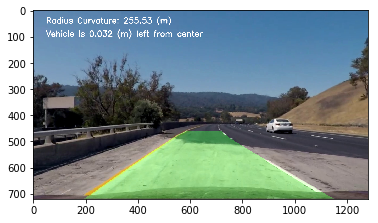

In [4]:
calibration_params = pickle.load(open('calibration_params.p', 'rb'))
mtx = calibration_params['mtx']
dist = calibration_params['dist']
image = mpimg.imread('test_images/difficult2.jpg')
out_img = pipeline(image, mtx, dist)
plt.imshow(out_img)
plt.imsave('output_images/filled_lane', out_img)

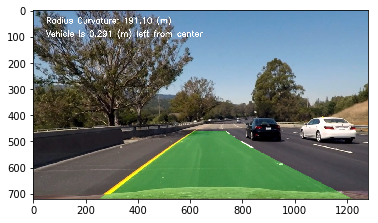

In [4]:
left_fit = np.array([1.35731604e-04, -3.03490785e-01, 5.02378752e+02])
right_fit = np.array([3.92766376e-04, -5.37018058e-01, 1.21213132e+03])
out_img = pipeline(image, mtx, dist, left_fit, right_fit)
plt.imshow(out_img)

### Process Video

In [5]:
def process_image(image):
    result = pipeline(image, mtx, dist)
    return result

[MoviePy] >>>> Building video output_images/my_output.mp4
[MoviePy] Writing video output_images/my_output.mp4


100%|█████████▉| 1260/1261 [05:54<00:00,  3.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/my_output.mp4 

CPU times: user 7min 38s, sys: 39.5 s, total: 8min 17s
Wall time: 5min 55s


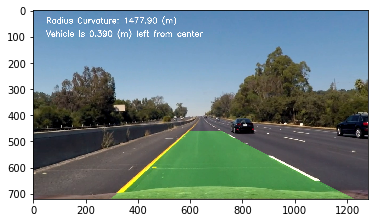

In [6]:
output_video = 'my_output_video.mp4'
clip = VideoFileClip("project_video.mp4")
res_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time res_clip.write_videofile(output_video, audio=False)

In [7]:
output_video = 'my_output_video.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))